In [145]:
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42
# plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["mathtext.fontset"] = "cm"
# plt.rcParams['axes.labelsize']=14
# plt.rcParams['xtick.labelsize']=11
# plt.rcParams['ytick.labelsize']=11

# plt.rcParams['axes.grid']=True
# plt.rcParams['axes.xmargin']=0

In [146]:
from pathlib import Path
import time
import torch
import numpy as np

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from transformer_onestep import GPTConfig, GPT
from transformer_onestep_CL import GPTClosedLoop

import argparse

In [147]:
fig_path = Path("fig")
fig_path.mkdir(exist_ok=True)

In [148]:
# Fix all random sources to make script fully reproducible
#torch.manual_seed(420)
#np.random.seed(430)
system_seed = 430 # Controls the system generation
data_seed = 0 # Control the input generation

In [149]:
# Overall settings
out_dir = "out"

# System settings
nu = 1
ny = 1
#seq_len = 600
batch_size = 50 # 256

# Compute settings
cuda_device = "cuda:0"
no_cuda = False
threads = 10
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
#torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
#torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn

In [150]:
torch.cuda.is_available()

True

In [151]:
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir/"ckpt_onestep_wh_try3.10.pt", map_location=device)

In [152]:
seq_len = exp_data["cfg"].seq_len
nx = exp_data["cfg"].nx

In [153]:
# del exp_data["model_args"]['use_pi']

In [154]:
model_args = exp_data["model_args"]
# model_args['use_p'] = True
# model_args['use_i'] = True
# model_args['use_d'] = False
gptconf = GPTConfig(**model_args)
model_CL = GPTClosedLoop(gptconf).to(device)

state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model_CL.load_state_dict(state_dict)
model = model_CL.gpt_model

number of parameters: 0.11M


In [155]:
print(f"Best validation loss: {exp_data['best_val_loss']}")

Best validation loss: 0.01257436815649271


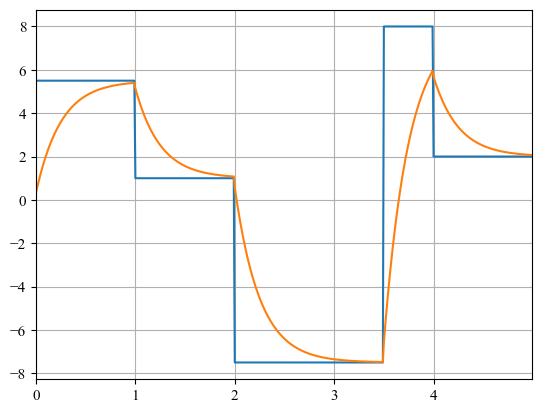

In [156]:
from control_torch import drss, set_seed, forced_response, tf2ss, c2d, perturb_matrices, perturb_parameters
batch_r_test = 20


T = 5
ts = 1e-2
t = torch.arange(0, T, ts, device=device, dtype=torch.float32).view(-1, 1)

R = torch.zeros([batch_r_test, len(t)], device=device, dtype=torch.float32)

# for j in range(batch_r_test):
#     r = torch.ones_like(t, device=device, dtype=torch.float32)
#     r[t < 1] = np.random.choice(np.arange(-10,10,.5))
#     r[(t >= 2) & (t < 3.5)] = np.random.choice(np.arange(-10,10,.5))
#     r[(t >= 3.5) & (t < 4)] = np.random.choice(np.arange(-10,10,.5))
#     r[(t >= 4) & (t < 5)] = np.random.choice(np.arange(-10,10,.5))
#     R[j] = r.reshape(-1)
    
r = torch.ones_like(t, device=device, dtype=torch.float32)
r[t < 1] = np.random.choice(np.arange(-10,10,.5))
r[(t >= 2) & (t < 3.5)] = np.random.choice(np.arange(-10,10,.5))
r[(t >= 3.5) & (t < 4)] = np.random.choice(np.arange(-10,10,.5))
r[(t >= 4) & (t < 5)] = np.random.choice(np.arange(-10,10,.5))

for j in range(batch_r_test):
    R[j] = r.reshape(-1)

tau = 1
M_num = torch.tensor([0.01, 1], device=device, dtype=torch.float32)  # Numerator coefficients
M_den = torch.tensor([tau/4, 1], device=device, dtype=torch.float32)  # Denominator coefficients
M = tf2ss(M_num, M_den, device=device)
M_d = c2d(*M, ts, device=device)

Y_D = torch.zeros([batch_r_test, len(t)], device=device, dtype=torch.float32)
for j in range(batch_r_test):
    y_d = forced_response(*M_d, R[j].reshape(-1,1))
    Y_D[j] = y_d.reshape(-1)

plt.plot(t.cpu().numpy(), R[0].cpu().numpy())
plt.plot(t.cpu().numpy(), Y_D[0].cpu().numpy())

In [157]:
set_seed(42)
perturb_percentage = 10
seq_len = 300
nx = 2
nu = 1
ny = 1

# define settings
n_in = 1
n_out = 1
n_hidden = 32
# define nominal model
G1_0 = drss(nx, nu, ny, device=device)
G2_0 = drss(nx, nu, ny, device=device)
w1_0 = torch.randn(n_hidden, n_in, device=device) / torch.sqrt(torch.tensor(n_in, dtype=torch.float32,device=device)) * (5 / 3)
b1_0 = torch.randn(1, n_hidden, device=device) * 1.0
w2_0 = torch.randn(n_out, n_hidden, device=device) / torch.sqrt(torch.tensor(n_hidden, dtype=torch.float32, device=device))
b2_0 = torch.randn(1, n_out, device=device) * 1.0

# G1 = perturb_matrices(*G1_0, percentage=perturb_percentage, device=device) #seems like this function 'cuts' small values
# G2 = perturb_matrices(*G2_0, percentage=perturb_percentage, device=device) # if i want to get the same Gs as in dataset i 
# w1 = perturb_parameters(w1_0, perturb_percentage, device = device)
# b1 = perturb_parameters(b1_0, perturb_percentage, device = device)
# w2 = perturb_parameters(w2_0, perturb_percentage, device = device)
# b2 = perturb_parameters(b2_0, perturb_percentage, device = device)

In [158]:
# print(model.proportional_coefficient)
# print(model.integral_coefficient)
# print(model.derivative_coefficient)

In [159]:
H = 500
def nn_fun(x,w1,b1,w2,b2):
    out = x @ w1.T + b1
    out = torch.tanh(out)
    out = out @ w2.T + b2
    return out

YY = torch.zeros([batch_r_test,len(t)], device=device, dtype=torch.float32)

for j in range(batch_r_test):    
    G1 = perturb_matrices(*G1_0, percentage=perturb_percentage, device=device) #seems like this function 'cuts' small values
    G2 = perturb_matrices(*G2_0, percentage=perturb_percentage, device=device) # if i want to get the same Gs as in dataset i 
    w1 = perturb_parameters(w1_0, perturb_percentage, device = device)
    b1 = perturb_parameters(b1_0, perturb_percentage, device = device)
    w2 = perturb_parameters(w2_0, perturb_percentage, device = device)
    b2 = perturb_parameters(b2_0, perturb_percentage, device = device)

    print('Reference n.',j)
    E = torch.empty_like(t, device=device, dtype=torch.float32).reshape(1,-1,1)
    U = torch.empty(t.size(0)+1, device=device, dtype=torch.float32).reshape(1,-1,1)
    Y1 = torch.empty_like(t, device=device, dtype=torch.float32).reshape(1,-1,1)
    Y2 = torch.empty_like(t, device=device, dtype=torch.float32).reshape(1,-1,1)
    Y = torch.empty_like(t, device=device, dtype=torch.float32).reshape(1,-1,1)
    
    
    with torch.no_grad():
        # initial
        U[0,0,0] = 0
        y1_i = 0
        y2_i = 0
        y_i = 0
        x1_i = torch.zeros(nx, device=device, dtype=torch.float32)
        x2_i = torch.zeros(nx, device=device, dtype=torch.float32)
        
        for i in range(len(t)):
            
            if (i % 100 == 0) : print('time instant:', i)
            # start the loop with error
            # e_i = R[j,i] - y_i
            e_i = Y_D[j,i] - y_i
                
            Y[0,i,0] = y_i
            Y1[0,i,0] = y1_i # this could be useful for checks
            Y2[0,i,0] = y2_i
            E[0,i,0] = e_i
            
            # Controller u(t) = C(e(t),u(t-1))
            if i < H:
                pred = model(E[:, :i+1, :], U[:, :i+1, :])
            else:
                pred = model(E[:, i-H+1:i+1, :], U[:, i-H+1:i+1, :])
                
            U[0,i+1,0] = pred[0,-1,0] # just for coherence, it could be directly be u_i_prev
            
            ##LOOK OUT FOR NECESSARY RESHAPINGS
            y1, x1_i = forced_response(*G1, U[0,i:i+2,:], return_x=True, x0=x1_i)
            y1_i = y1[-1]
            
            y2 = nn_fun(y1_i,w1,b1,w2,b2)
            y2_i = y2[-1]
            
            y2_i = y2_i.reshape(-1,1)
            y, x2_i = forced_response(*G2, y2_i, return_x=True, x0=x2_i)
            y_i = y[-1] * 7.5
    YY[j] = Y[0,:,0]

Reference n. 0
time instant: 0
time instant: 100
time instant: 200
time instant: 300
time instant: 400
Reference n. 1
time instant: 0
time instant: 100
time instant: 200
time instant: 300
time instant: 400
Reference n. 2
time instant: 0
time instant: 100
time instant: 200
time instant: 300
time instant: 400
Reference n. 3
time instant: 0
time instant: 100
time instant: 200
time instant: 300
time instant: 400
Reference n. 4
time instant: 0
time instant: 100
time instant: 200
time instant: 300
time instant: 400
Reference n. 5
time instant: 0
time instant: 100
time instant: 200
time instant: 300
time instant: 400
Reference n. 6
time instant: 0
time instant: 100
time instant: 200
time instant: 300
time instant: 400
Reference n. 7
time instant: 0
time instant: 100
time instant: 200
time instant: 300
time instant: 400
Reference n. 8
time instant: 0
time instant: 100
time instant: 200
time instant: 300
time instant: 400
Reference n. 9
time instant: 0
time instant: 100
time instant: 200
time i

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


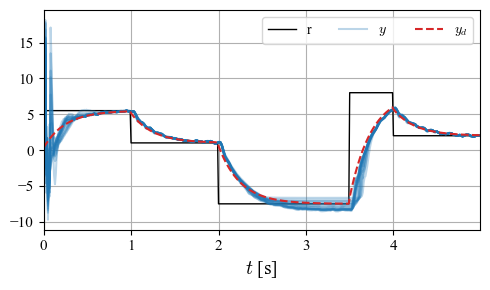

In [163]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

# cmap = plt.get_cmap('tab10')  # You can use any colormap you like
# colors = [cmap(i) for i in range(batch_r_test)]
# colors2 = ['b', 'r', 'g']

plt.figure(figsize=(5, 3))

plt.plot(t.cpu().numpy(), R[0].cpu().numpy(), label='$r$', c='k', alpha=1, linewidth=1)
plt.plot(t.cpu().numpy(), YY[0].cpu().numpy(), c='tab:blue', alpha=.3, label='$y$')

for i in range(1, batch_r_test):
    # color = colors[i]
    # color2 = colors2[i]
    plt.plot(t.cpu().numpy(), YY[i].cpu().numpy(), c='tab:blue', alpha=.3, label='_nolegend_')

plt.plot(t.cpu().numpy(), Y_D[0].cpu().numpy(), c='tab:red', alpha=1, linestyle='--', label='$y_d$')

plt.xlabel('$t$ [s]')
# plt.title('Desired Outputs (--) , and Simulations')
# plt.ylim([-11, 11])
plt.legend(['r','$y$','$y_d$'], loc='upper right', ncol=3)
plt.grid(True)
plt.tight_layout()
plt.savefig('wh_test_1.pdf')
plt.show()

In [99]:
batch_r_test

20

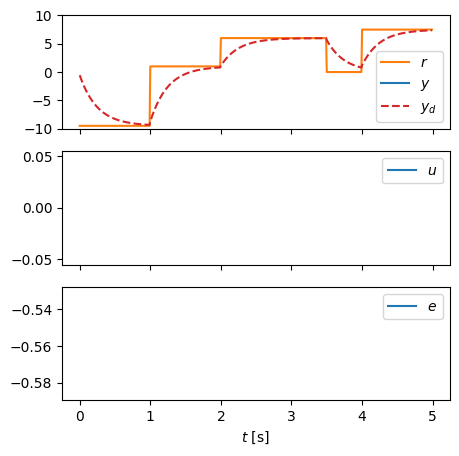

In [17]:
## THIS PLOT REFERS TO THE LAST SAMPLE
fig = plt.figure(figsize=(5, 5))
ax1 = plt.subplot(311)
#plt.plot(t_CL, r)
plt.plot(t.cpu().numpy(), R[batch_r_test-1].cpu().numpy(), label="$r$", c='tab:orange')
plt.plot(t.cpu().numpy(), YY[batch_r_test-1].cpu().numpy(), label="$y$", c='tab:blue', alpha=1)
plt.plot(t.cpu().numpy(), Y_D[batch_r_test-1].cpu().numpy(), label="$y_d$", c='tab:red', alpha=1, linestyle='--')
plt.legend(['$r$','$y$','$y_d$'])
# plt.xlim([0, 0.43])
plt.ylim([-10, 10])
plt.tick_params('x', labelbottom=False)

ax2 = plt.subplot(312, sharex=ax1)
plt.plot(t.cpu().numpy(), U[0,1:,0].cpu().numpy(), c='tab:blue', alpha=1)
# plt.plot(t_CL[:-1], batch_u[0,1:,0] * u_std, c='tab:green', alpha=1)
plt.legend(['$u$', '$u_{ideal}$'])
# plt.xlim([10, 12])
plt.tick_params('x', labelbottom=False)

ax3 = plt.subplot(313, sharex=ax1)
plt.plot(t.cpu().numpy(), E[0,:,0].cpu().numpy(), c='tab:blue', alpha=1)
# plt.plot(t_CL, batch_e[0,:,0] * e_std, c='tab:green', alpha=1)
plt.xlabel('$t$ [s]')
# plt.ylim([0, 4])
plt.legend(['$e$', '$e_{ideal}$'])

# plt.savefig('transformer_controller.pdf')

plt.show()

In [18]:
##MEAN SQUARED ERROR
MSE = np.zeros([batch_r_test,1])
for j in range(batch_r_test) :
    error = np.array(Y_D[j].cpu() - YY[j].cpu())
    squared_error_sum = 0
    for i in range(len(error)) :
        squared_error_sum = squared_error_sum + (error[i]*error[i])
    mse = squared_error_sum / len(error)
    print('mse of simulation n. ',j ,':',mse)
    MSE[j] = mse
total_MSE = 0
for j in range(batch_r_test) :
    total_MSE += MSE[j]
total_MSE = total_MSE / batch_r_test 
print('total MSE :', total_MSE)


mse of simulation n.  0 : nan
mse of simulation n.  1 : nan
mse of simulation n.  2 : nan
total MSE : [nan]
